# Information Retrival Project

Authors: Delia Mennitti - 19610, Letizia Meroi - , Sara Napolitano - 

For this project, we use the **SWIM-IR dataset**, which is described in detail in the paper *“Leveraging LLMs for Synthesizing Training Data Across Many Languages in Multilingual Dense Retrieval”* by Nandan Thakur, Jianmo Ni, Gustavo Hernández Ábrego, John Wieting, Jimmy Lin, and Daniel Cer.

## Task Definition

We focus on a **cross-lingual Information Retrieval (IR) task** using the SWIM-IR dataset.

Given an English query, the objective is to **retrieve the relevant Wikipedia passage written in another language**. Each query has exactly one associated relevant passage, enabling **automatic and reproducible evaluation** of retrieval performance.


In [1]:
import os
import json
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
import ast
from rank_bm25 import BM25Okapi
import jieba

/opt/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/jieba/_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Exploratory Data Analysis

Some stats, bar charts, how is the dataset structured etc...

In [2]:
# Base data directory
BASE_DATA_DIR = "data/swim_ir_v1/swim_ir_v1"

In [3]:
# Full path to Chinese cross-lingual train file
zh_path = os.path.join(BASE_DATA_DIR, "cross_lingual", "zh", "train.jsonl")

with open(zh_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i >= 5:
            break


{'_id': '18', 'lang': 'Chinese', 'code': 'zh', 'query': '1869 年，哪个国家发生了一起抢劫案？', 'title': '!Kora Wars', 'text': 'Jan Kivido and Piet Rooi formed a partnership and were the most consistent raiders. The first recorded significant incident between the !Kora people and the colonial government occurred in 1869, when a Griqua and Scottish trader were robbed along the southern bank of the Orange River. Piet Rooi, the leader of another nomadic !Kora group, was held responsible for the robbery, and as punishment was lashed and committed to three months hard labour. He was subsequently released on account of insufficient evidence against him. The treatment he received did not sit well with many of the !Ikora raiders, and this'}
{'_id': '39', 'lang': 'Chinese', 'code': 'zh', 'query': '电影《女性艺术革命》是关于什么的？', 'title': '!Women Art Revolution', 'text': 'historians for over 4 decades about their individual and group efforts to help women succeed in the art world and society by helping them overcome obstac

In [4]:
import gc

def encode_texts(texts, batch_size=1):
    """Encode texts to embeddings.
    EXTREMELY CONSERVATIVE: batch_size=1 (process one at a time)
    This should prevent kernel crash on M3 Mac 16GB RAM.
    """
    if not globals().get('RUN_DENSE', False):
        raise RuntimeError('Dense encoding was disabled (RUN_DENSE=False)')
    
    if not texts:
        raise ValueError('No texts provided for encoding')
    
    try:
        print(f"  Encoding {len(texts)} texts with batch_size={batch_size}...")
        embeddings = model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True  # important for cosine similarity
        )
        # Force garbage collection after encoding
        gc.collect()
        return embeddings
    except MemoryError as me:
        print(f'[ERROR] MemoryError during encoding: {me}')
        print('[TIP] Memory exhausted - try disabling RUN_DENSE or reducing MAX_ITEMS to 2')
        gc.collect()
        raise
    except Exception as e:
        print(f'[ERROR] Error during encoding: {e}')
        gc.collect()
        raise

# Full BM25 baseline for all languages Available

In [12]:
# Run BM25 for each language folder under each split (cross_lingual, monolingual, etc.)
CORPUS_SPLITS = [d for d in os.listdir(BASE_DATA_DIR) if os.path.isdir(os.path.join(BASE_DATA_DIR, d))]

# Fixed set of languages to process (Italian not available in dataset)
SELECTED_LANGUAGES = ['de', 'fr', 'es', 'en', 'zh']  # German, French, Spanish, English, Chinese

# Start with 5 items - sklearn is more stable than FAISS
MAX_ITEMS = 1000 
K = 10  # top-K retrieval

# Robust JSONL loader
def load_jsonl_robust(path, max_items=1000):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_items and i >= max_items:
                break
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                obj = ast.literal_eval(line)
            data.append(obj)
    return data

# Tokenizer
def tokenize(text, lang_code):
    if lang_code == "zh":
        return list(jieba.cut(text))
    else:
        return text.lower().split()

# Evaluation
def evaluate(retrieved, qrels, K=10):
    recalls = []
    rr_list = []
    for qid, top_docs in retrieved.items():
        relevant_doc = qrels[qid]
        recalls.append(1.0 if relevant_doc in top_docs[:K] else 0.0)
        try:
            rank = top_docs.index(relevant_doc) + 1
            rr_list.append(1.0 / rank)
        except ValueError:
            rr_list.append(0.0)
    return np.mean(recalls), np.mean(rr_list)

# Store results
results = []

print("NOTE: Encoding will happen once per language (not a bug!)")
print("Each language has different documents/queries that need separate embeddings.")
print(f"Processing selected languages: {', '.join(SELECTED_LANGUAGES)}\n")

for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    
    for lang_code in os.listdir(split_path):
        # Only process selected languages
        if lang_code not in SELECTED_LANGUAGES:
            continue
            
        lang_dir = os.path.join(split_path, lang_code)
        lang_path = os.path.join(lang_dir, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        print(f"\n{'='*60}")
        print(f"Processing {split}/{lang_code}")
        print('='*60)
        data = load_jsonl_robust(lang_path, max_items=MAX_ITEMS)

        # Build documents, queries, qrels
        documents = {}
        queries = {}
        qrels = {}
        for item in data:
            doc_id = f"{lang_code}_{item['_id']}"
            lang_field = item.get("code", lang_code)
            documents[doc_id] = {"text": item.get("title", "") + " " + item.get("text", ""), "lang": lang_field}
            queries[doc_id] = item.get("query", "")
            qrels[doc_id] = doc_id

        # Tokenize corpus
        doc_ids = list(documents.keys())
        tokenized_corpus = [tokenize(documents[doc_id]["text"], documents[doc_id]["lang"]) for doc_id in doc_ids]
        if len(tokenized_corpus) == 0:
            print("No documents found, skipping.")
            continue
        bm25 = BM25Okapi(tokenized_corpus)

        # Tokenize queries
        tokenized_queries = {qid: tokenize(q, documents[qid]["lang"]) for qid, q in queries.items()}

        # Retrieve top-K
        retrieved = {}
        for qid, query_tokens in tokenized_queries.items():
            scores = bm25.get_scores(query_tokens)
            top_indices = scores.argsort()[-K:][::-1]
            retrieved[qid] = [doc_ids[i] for i in top_indices]

        # Evaluate
        recall, mrr = evaluate(retrieved, qrels, K=K)
        results.append({"split": split, "language": lang_code, "Recall@10": recall, "MRR@10": mrr, "method": "BM25"})
        print(f"[OK] BM25 - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")

        # Dense retrieval for this language using sklearn (no FAISS!)
        if globals().get('RUN_DENSE', False):
            try:
                # Encode documents
                doc_texts = [documents[doc_id]["text"] for doc_id in doc_ids]
                print(f"\n[DENSE] Encoding {len(doc_texts)} documents...")
                doc_embeddings = encode_texts(doc_texts)
                print(f"[OK] Document embeddings shape: {doc_embeddings.shape}")

                # Encode queries
                query_ids = list(queries.keys())
                query_texts = [queries[qid] for qid in query_ids]
                print(f"\n[DENSE] Encoding {len(query_texts)} queries...")
                query_embeddings = encode_texts(query_texts)
                print(f"[OK] Query embeddings shape: {query_embeddings.shape}")

                # Use sklearn cosine_similarity instead of FAISS
                print(f"\n[DENSE] Computing cosine similarities...")
                # Compute similarity matrix: queries x documents
                similarities = cosine_similarity(query_embeddings, doc_embeddings)
                print(f"[OK] Similarity matrix shape: {similarities.shape}")
                
                # Get top-K for each query
                retrieved = {}
                for i, qid in enumerate(query_ids):
                    # Get similarities for this query
                    query_sims = similarities[i]
                    # Get top-K indices
                    top_indices = query_sims.argsort()[-K:][::-1]
                    retrieved[qid] = [doc_ids[idx] for idx in top_indices]
                    print(f"  Query {i+1}/{len(query_ids)}: done")

                # Evaluate
                recall, mrr = evaluate(retrieved, qrels, K=K)
                results.append({
                    "split": split,
                    "language": lang_code,
                    "Recall@10": recall,
                    "MRR@10": mrr,
                    "method": "LaBSE"
                })
                print(f"\n[OK] LaBSE - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")
                
                # Clean up
                del doc_embeddings, query_embeddings, similarities
                gc.collect()
                
            except Exception as e:
                print(f"\n[ERROR] Dense retrieval failed for {split}/{lang_code}: {e}")
                print("Continuing with next language...")
                import traceback
                traceback.print_exc()
                gc.collect()
        
        gc.collect()

# Display summary table
print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
df_results = pd.DataFrame(results)
print(f"\nTotal experiments: {len(df_results)}")

# Check if dense retrieval ran
if 'LaBSE' in df_results['method'].values:
    print("[OK] Both BM25 and LaBSE results collected")
else:
    print("[WARNING] Only BM25 results found. To run dense retrieval:")
    print("  1. Run cell 14 to load the model (RUN_DENSE=True)")
    print("  2. Then re-run this cell (cell 11)")

print(f"\n[OK] Using sklearn cosine_similarity - much more stable!")
print(f"If stable, increase MAX_ITEMS: 5 -> 10 -> 25 -> 50 -> 100")

df_results

NOTE: Encoding will happen once per language (not a bug!)
Each language has different documents/queries that need separate embeddings.
Processing selected languages: de, fr, es, en, zh


Processing monolingual/de
[OK] BM25 - Recall@10: 0.8170, MRR@10: 0.7556

[DENSE] Encoding 1000 documents...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

,split,language,Recall@10,MRR@10,method
0,monolingual,de,0.817,0.755586,BM25
1,monolingual,de,0.888,0.796306,LaBSE
2,monolingual,fr,0.609,0.503523,BM25
3,monolingual,fr,0.761,0.610283,LaBSE
4,monolingual,es,0.797,0.702014,BM25
5,monolingual,es,0.861,0.730001,LaBSE
6,monolingual,en,0.939,0.880351,BM25
7,monolingual,en,0.930,0.844212,LaBSE
8,cross_lingual,zh,0.612,0.527670,BM25
9,cross_lingual,zh,0.854,0.674460,LaBSE


# Dense Multilingual Retrieval Using Embeddings

We use **LaBSE** (Language-agnostic BERT Sentence Embedding) to encode queries and passages.

For similarity computation, we use **sklearn's cosine_similarity** instead of FAISS, which is more stable and memory-efficient for small to medium datasets.

| Model                                               | Strengths                      | Notes                                   |
| --------------------------------------------------- | ------------------------------ | --------------------------------------- |
| **LaBSE** (`sentence-transformers/LaBSE`)           | Strong cross-lingual alignment | Excellent zero-shot multilingual IR     |
| **mSBERT** (`distiluse-base-multilingual-cased-v2`) | Faster, lighter                | Slightly weaker cross-lingual alignment |
| **XLM-R** (fine-tuned)                              | Flexible                       | Needs pooling + tuning for IR           |

In [6]:
# Dense retrieval: Using sklearn instead of FAISS (more stable)
RUN_DENSE = True  # set to False to skip dense retrieval

if RUN_DENSE:
    try:
        from sentence_transformers import SentenceTransformer
        from sklearn.metrics.pairwise import cosine_similarity
        import numpy as np
        model = SentenceTransformer("sentence-transformers/LaBSE")
        print('[OK] LaBSE model loaded')
        print('[OK] Using sklearn cosine_similarity (more stable than FAISS)')
    except Exception as e:
        print('Failed to load dense model:', e)
        RUN_DENSE = False
else:
    print('Dense retrieval disabled (RUN_DENSE=False)')

[OK] LaBSE model loaded
[OK] Using sklearn cosine_similarity (more stable than FAISS)


## Encode Queries and Retrieve

In [8]:
# NOTE: This cell is for standalone testing only.
# The main loop (cell 11) already includes dense retrieval with sklearn.
# Only run this if you want to test encoding separately.

# Check if required variables exist
if 'documents' not in globals() or 'doc_ids' not in globals():
    print('[WARNING] Variables not defined. This cell requires the main loop to run first.')
    print('Or define documents and doc_ids manually for testing.')
else:
    if not globals().get('RUN_DENSE', False):
        print('Dense retrieval disabled (RUN_DENSE=False)')
    else:
        try:
            from sklearn.metrics.pairwise import cosine_similarity
            
            doc_texts = [documents[doc_id]["text"] for doc_id in doc_ids]
            print(f"Encoding {len(doc_texts)} documents...")
            doc_embeddings = encode_texts(doc_texts)

            print(f'[OK] Embeddings built: {len(doc_texts)} documents, dimension {doc_embeddings.shape[1]}')
            print('[OK] Using sklearn cosine_similarity (no FAISS)')
        except Exception as e:
            print(f'Error building embeddings: {e}')
            import gc
            gc.collect()

Encoding 1000 documents...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Embeddings built: 1000 documents, dimension 768
[OK] Using sklearn cosine_similarity (no FAISS)


In [9]:
# NOTE: This cell is for standalone testing only.
# The main loop (cell 11) already includes dense retrieval with evaluation.
# Only run this if you want to test query retrieval separately.

# Check if required variables are defined
required_vars = ['doc_embeddings', 'queries', 'doc_ids', 'K']
missing = [v for v in required_vars if v not in globals()]

if missing:
    print(f'[WARNING] Missing variables: {", ".join(missing)}')
    print('This cell requires running the previous cells first.')
    print('The main loop (cell 11) already includes dense retrieval - check results there.')
elif not globals().get('RUN_DENSE', False):
    print('Dense retrieval disabled (RUN_DENSE=False)')
else:
    try:
        from sklearn.metrics.pairwise import cosine_similarity
        
        # Encode queries
        query_ids = list(queries.keys())
        query_texts = [queries[qid] for qid in query_ids]
        print(f"Encoding {len(query_texts)} queries...")
        
        query_embeddings = encode_texts(query_texts)
        
        # Retrieve using sklearn cosine_similarity (no FAISS!)
        print(f"Computing similarities with sklearn...")
        similarities = cosine_similarity(query_embeddings, doc_embeddings)
        
        retrieved = {}
        for q_idx, qid in enumerate(query_ids):
            query_sims = similarities[q_idx]
            top_indices = query_sims.argsort()[-K:][::-1]
            retrieved[qid] = [doc_ids[i] for i in top_indices]
        
        print(f'[OK] Retrieved top-{K} results for {len(query_ids)} queries using sklearn')
        
    except Exception as e:
        print(f'Error during retrieval: {e}')
        print('Possible causes:')
        print('  - Memory issue: reduce MAX_ITEMS or batch_size')
        print('  - Variables from different language iteration')
        import gc
        gc.collect()

Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing similarities with sklearn...
[OK] Retrieved top-10 results for 1000 queries using sklearn


## Results Analysis

We use **LaBSE** (Language-agnostic BERT Sentence Embedding), which is a BERT-based encoder that:
- Encodes text into dense 768-dimensional vectors
- Uses BERT architecture pre-trained on 109 languages
- Computes semantic similarity via cosine similarity (sklearn)

**Metrics (same as BM25):**
- **Recall@10**: Percentage of queries where the relevant document appears in top-10 results
- **MRR@10**: Mean Reciprocal Rank - measures how high the relevant document ranks

DETAILED RESULTS COMPARISON: BM25 vs LaBSE (Dense BERT)

[RESULTS] All Results:
        split language  Recall@10   MRR@10 method
  monolingual       de      0.817 0.755586   BM25
  monolingual       de      0.888 0.796306  LaBSE
  monolingual       fr      0.609 0.503523   BM25
  monolingual       fr      0.761 0.610283  LaBSE
  monolingual       es      0.797 0.702014   BM25
  monolingual       es      0.861 0.730001  LaBSE
  monolingual       en      0.939 0.880351   BM25
  monolingual       en      0.930 0.844212  LaBSE
cross_lingual       zh      0.612 0.527670   BM25
cross_lingual       zh      0.854 0.674460  LaBSE
cross_lingual       de      0.573 0.463371   BM25
cross_lingual       de      0.852 0.679094  LaBSE
cross_lingual       fr      0.578 0.441651   BM25
cross_lingual       fr      0.794 0.619787  LaBSE
cross_lingual       es      0.425 0.294313   BM25
cross_lingual       es      0.853 0.672921  LaBSE

AVERAGE PERFORMANCE BY METHOD
        Recall@10    MRR@10
method     

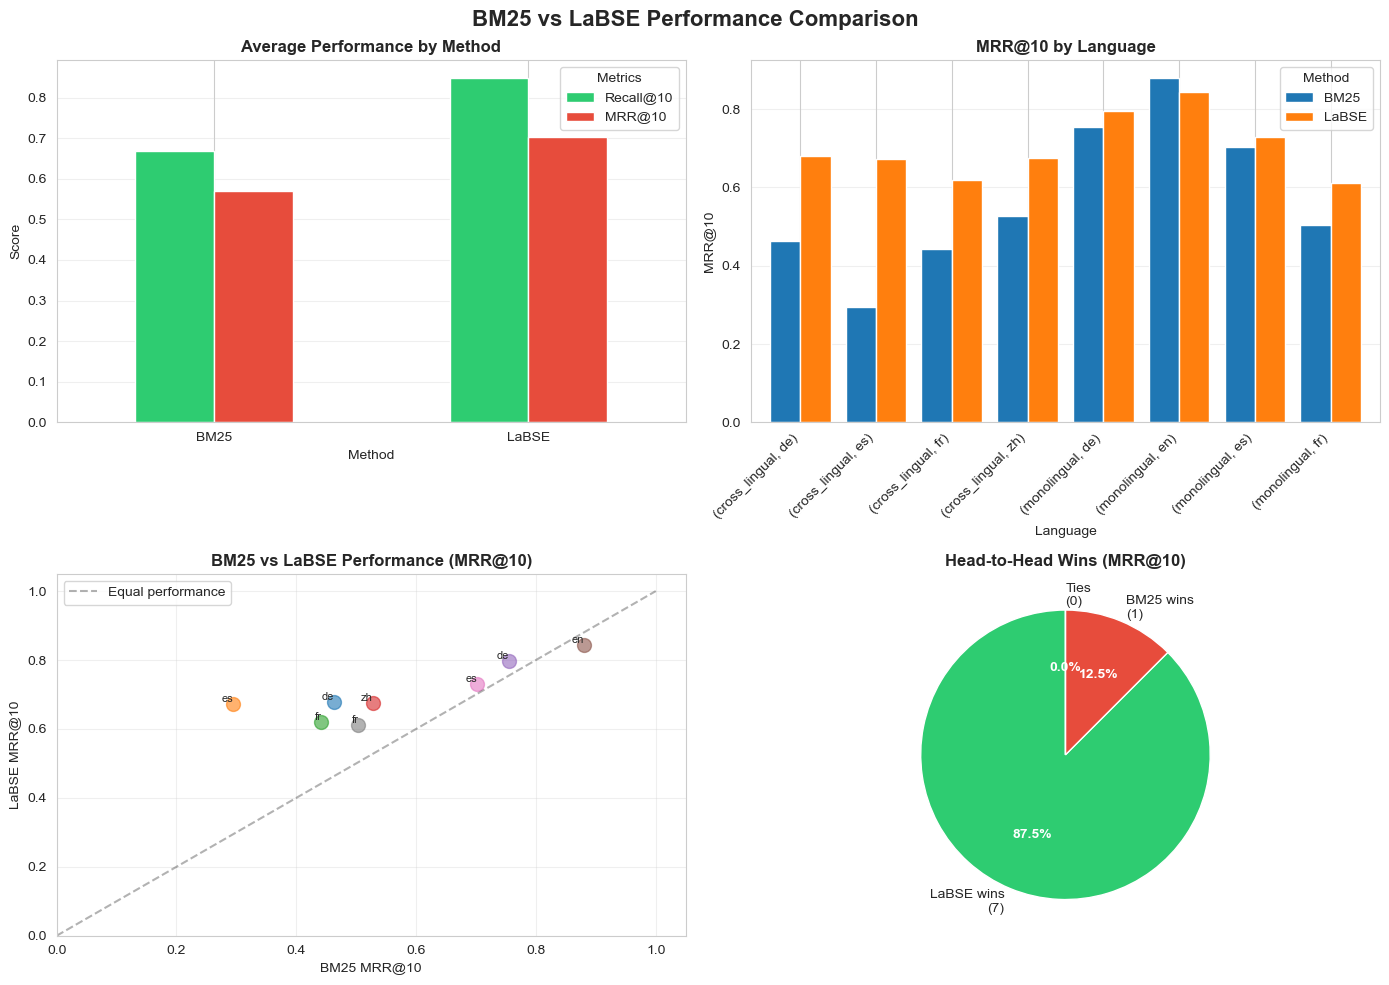

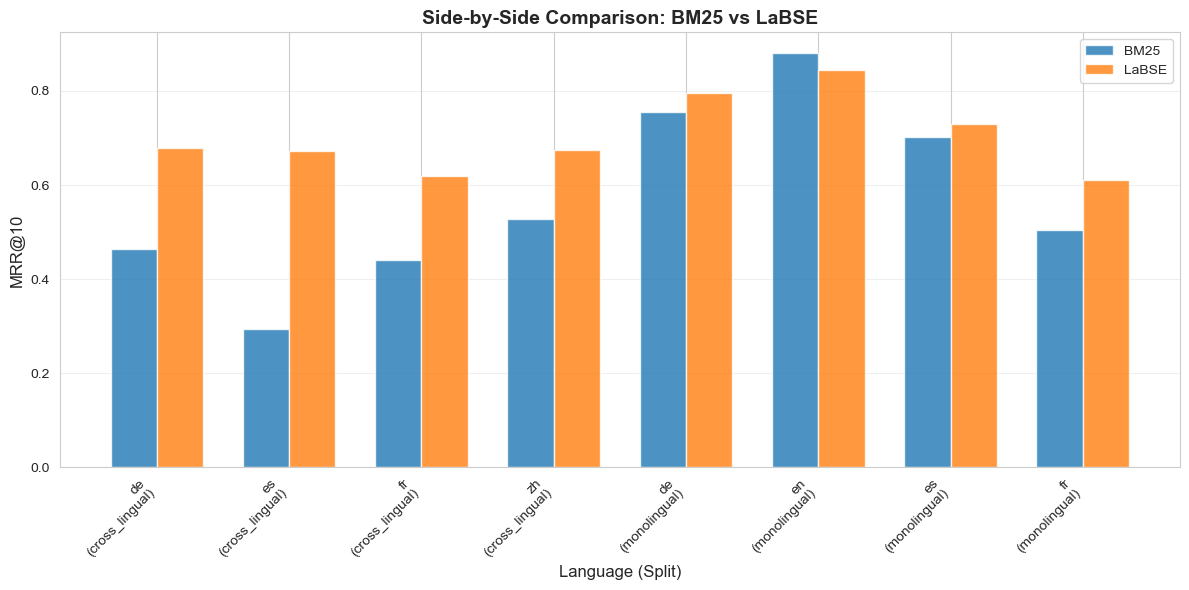

In [13]:
# Analyze and compare BM25 vs LaBSE (Dense BERT-based retrieval)
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_results' in globals() and not df_results.empty:
    print("="*70)
    print("DETAILED RESULTS COMPARISON: BM25 vs LaBSE (Dense BERT)")
    print("="*70)
    
    # Show all results
    print("\n[RESULTS] All Results:")
    print(df_results.to_string(index=False))
    
    # Compare by method
    print("\n" + "="*70)
    print("AVERAGE PERFORMANCE BY METHOD")
    print("="*70)
    method_avg = df_results.groupby('method')[['Recall@10', 'MRR@10']].mean()
    print(method_avg)
    
    # Compare by language
    print("\n" + "="*70)
    print("PERFORMANCE BY LANGUAGE")
    print("="*70)
    
    # Pivot table for easier comparison
    pivot_recall = df_results.pivot_table(
        values='Recall@10', 
        index=['split', 'language'], 
        columns='method'
    ).fillna(0)
    
    pivot_mrr = df_results.pivot_table(
        values='MRR@10', 
        index=['split', 'language'], 
        columns='method'
    ).fillna(0)
    
    print("\n[METRICS] Recall@10 by Language:")
    print(pivot_recall)
    
    print("\n[METRICS] MRR@10 by Language:")
    print(pivot_mrr)
    
    # Count wins
    if 'LaBSE' in df_results['method'].values and 'BM25' in df_results['method'].values:
        print("\n" + "="*70)
        print("HEAD-TO-HEAD COMPARISON")
        print("="*70)
        
        # Compare on Recall@10
        better_recall = (pivot_recall['LaBSE'] > pivot_recall['BM25']).sum()
        worse_recall = (pivot_recall['LaBSE'] < pivot_recall['BM25']).sum()
        tie_recall = (pivot_recall['LaBSE'] == pivot_recall['BM25']).sum()
        
        print(f"\n[COMPARISON] Recall@10 comparison:")
        print(f"  LaBSE wins: {better_recall}")
        print(f"  BM25 wins: {worse_recall}")
        print(f"  Ties: {tie_recall}")
        
        # Compare on MRR@10
        better_mrr = (pivot_mrr['LaBSE'] > pivot_mrr['BM25']).sum()
        worse_mrr = (pivot_mrr['LaBSE'] < pivot_mrr['BM25']).sum()
        tie_mrr = (pivot_mrr['LaBSE'] == pivot_mrr['BM25']).sum()
        
        print(f"\n[COMPARISON] MRR@10 comparison:")
        print(f"  LaBSE wins: {better_mrr}")
        print(f"  BM25 wins: {worse_mrr}")
        print(f"  Ties: {tie_mrr}")
        
        print("\n[INFO] LaBSE uses BERT-based dense embeddings (768-dim vectors)")
        print("[INFO] sklearn cosine_similarity for retrieval (no FAISS)")
        
        # Visualization plots
        print("\n" + "="*70)
        print("VISUALIZATIONS")
        print("="*70)
        
        # Set style
        sns.set_style("whitegrid")
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('BM25 vs LaBSE Performance Comparison', fontsize=16, fontweight='bold')
        
        # 1. Bar chart: Average metrics by method
        ax1 = axes[0, 0]
        method_avg.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
        ax1.set_title('Average Performance by Method', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Method')
        ax1.set_ylabel('Score')
        ax1.legend(title='Metrics')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. Grouped bar chart: MRR@10 by language
        ax2 = axes[0, 1]
        pivot_mrr.plot(kind='bar', ax=ax2, width=0.8)
        ax2.set_title('MRR@10 by Language', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Language')
        ax2.set_ylabel('MRR@10')
        ax2.legend(title='Method')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Scatter plot: BM25 vs LaBSE (MRR)
        ax3 = axes[1, 0]
        for idx, row in pivot_mrr.iterrows():
            split, lang = idx if isinstance(idx, tuple) else (idx, idx)
            ax3.scatter(row['BM25'], row['LaBSE'], s=100, alpha=0.6)
            ax3.annotate(lang, (row['BM25'], row['LaBSE']), 
                        fontsize=8, ha='right', va='bottom')
        
        # Add diagonal line
        max_val = max(pivot_mrr.max().max(), 1.0)
        ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Equal performance')
        ax3.set_xlim(0, max_val * 1.05)
        ax3.set_ylim(0, max_val * 1.05)
        ax3.set_xlabel('BM25 MRR@10')
        ax3.set_ylabel('LaBSE MRR@10')
        ax3.set_title('BM25 vs LaBSE Performance (MRR@10)', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Win/Loss pie chart
        ax4 = axes[1, 1]
        win_data = [better_mrr, worse_mrr, tie_mrr]
        labels = [f'LaBSE wins\n({better_mrr})', f'BM25 wins\n({worse_mrr})', f'Ties\n({tie_mrr})']
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']
        wedges, texts, autotexts = ax4.pie(win_data, labels=labels, colors=colors, 
                                             autopct='%1.1f%%', startangle=90)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        ax4.set_title('Head-to-Head Wins (MRR@10)', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot: Language-wise comparison
        if len(pivot_mrr) > 1:
            fig2, ax = plt.subplots(figsize=(12, 6))
            x = range(len(pivot_mrr))
            width = 0.35
            
            ax.bar([i - width/2 for i in x], pivot_mrr['BM25'], width, label='BM25', alpha=0.8)
            ax.bar([i + width/2 for i in x], pivot_mrr['LaBSE'], width, label='LaBSE', alpha=0.8)
            
            ax.set_xlabel('Language (Split)', fontsize=12)
            ax.set_ylabel('MRR@10', fontsize=12)
            ax.set_title('Side-by-Side Comparison: BM25 vs LaBSE', fontsize=14, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels([f"{idx[1]}\n({idx[0]})" for idx in pivot_mrr.index], 
                              rotation=45, ha='right')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
else:
    print("[WARNING] No results available. Run the main loop (cell 11) first.")

# Hybrid Approach (BM25 + Dense Retrieval)
Combine BM25 scores and dense retrieval scores

Test weighted combination or re-ranking

Compare improvements over BM25-only or dense-only

# Neural Reranking on Top-K Results

Optional but nice to have

Use cross-encoder models to rerank top-K retrieved passages

Improves semantic matching on hard queries

# Results and Conclusions